<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Plane's Windows</div>
<div style="font-size:18pt; line-height:25pt; text-align:center;">Daniela Andrioaie</div>
<div style="font-size:18pt; line-height:25pt; text-align:center;">Colas Drutinus--Cabin</div>

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import math

from sklearn.decomposition import PCA

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [60]:
data = pd.read_csv("./data/dataset.csv")

# Liste des noms des fenêtres
windows = sorted(list(set(data['day_cycle_window'])))

# nombre de fenêtres
n_window = len(windows)

# nombre de données
n_data = data.shape[0]

#### This exercices aims to build an algorithm to detect windows which are abnormal.

1. [Etude de faisabilité](#sec1)
2. [Détection d'anomalies](#sec2)
    1. [Représentation de chaque fenêtre par sa moyenne](#sec2-1)
        1. [Analyse en composantes principales](#sec2-1-1)
        2. [Méthodes de détection](#sec2-1-2)
        3. [Résultats](#sec2-1-3)
    2. [Etude de toutes les données](#sec2-2)
       1. [Analyse en composantes principales](#sec2-2-1)
       2. [Méthodes de détection](#sec2-2-2)
       3. [Résultats](#sec2-2-3)
3. [Analyse des résultats](#sec3)

# <a id="sec1"></a> 1. Etude de faisabilité

Nous allons, dans cette étude, essayer de détecter des anomalies dans un dataset inconnu. Pour cela, nous allons utiliser plusieurs méthodes issues du champ de la Data Science. 

Il faut garder en mémoire que ces algorithmes ne permettent en aucun cas de délivrer un jugement final sur l'anormalité des données détectées. En effet, le dataset à étudier est complètement inconnu : pas de connaissance du modèle physique, et pas de connaissance des différents paramètres, puisque ceux-ci ont été normalisés.

De plus, dans un souci de représentation des données, nous allons les pré-traiter en effectuant une Analyse en Composantes Principales (ACP). Cette méthode est nécessaire pour pouvoir visualiser les données, et ainsi avoir un premier ordre de grandeur pour le contamination rate à utiliser par la suite. Cependant, cette méthode nous fera perdre des informations, puisqu'elle ne peut expliquer que 75% de la variance en deux dimensions (et 80% en trois dimensions).

Ainsi, il sera nécessaire de présenter les résultats à un expert ayant connaissance de la signification des données que nous étudions. Il sera capable d'analyser le comportement normal du système physique, pourra gérer les hyperparamètres des méthodes utilisées (contamination rate notamment), et délivrera une conclusion finale quant aux différentes fenêtres anormales.

# <a id="sec2"></a> 2. Détection d'anomalies

## <a id="sec2-1"></a> A. Représentation de chaque fenêtre par sa moyenne

On va regarder s'il existe des "gros" outliers (données n'étant pas du même ordre de grandeur) dans le dataset. Si c'est le cas, ces valeurs seront retirées. Pour ce faire, nous allons comparer la moyenne et la médiane de chaque fenêtre. Si l'écart relatif entre ces deux valeurs est élevé, cela signifie qu'un "gros" outlier se situe dans la fenêtre considérée.

Rappel : $e = \lvert \frac{med(x) - moy(x)}{min(med(x);moy(x))} \rvert$

In [64]:
df_med = data.groupby(['day_cycle_window']).median()
df_mean = data.groupby(['day_cycle_window']).mean()

# Calcul des écarts relatifs
distances = []
for i in range(df_mean.shape[0]):
    dist = 0
    for col in df_mean.columns:
        dist += abs((df_mean[col][i]-df_med[col][i])/np.max([abs(df_mean[col][i]), abs(df_med[col][i])]))
    distances.append(round(dist,2))


print("Médiane des écarts relatifs : {}".format(np.median(distances)))

Médiane des écarts relatifs : 0.73


Comme les écarts entre médiane et moyenne sont assez faibles, le choix de représenter chaque fenêtre par sa valeur moyenne semble cohérent.

### <a id="sec2-1-1"></a> a. Analyse en composantes principales

Comme nous avons un tableau de données avec 11 variables, il est difficile de représenter graphiquement les données. Pour cela, nous allons utiliser une Analyse en Composantes Principales pour nous ramener à un problème en 2D, puis 3D.

In [41]:
# ACP en 2D
pca_mean = PCA(n_components=2)

principalComponents = pca_mean.fit_transform(df_mean)

# Tableau de coordonnées des données initiales dans le plan principal
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# Variance expliquée par les deux composantes principales
print("Variance expliquée : {}%".format(round(np.sum(pca_mean.explained_variance_ratio_)*100,2)))

Variance expliquée : 75.63%


In [42]:
# ACP en 3D
pca3_mean = PCA(n_components=3)

principalComponents3 = pca3_mean.fit_transform(df_mean)

# Tableau de coordonnées des données initiales dans le plan principal
principalDf3 = pd.DataFrame(data = principalComponents3
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

# Variance expliquée par les deux composantes principales
print("Variance expliquée : {}%".format(round(np.sum(pca3_mean.explained_variance_ratio_)*100,2)))

Variance expliquée : 80.17%


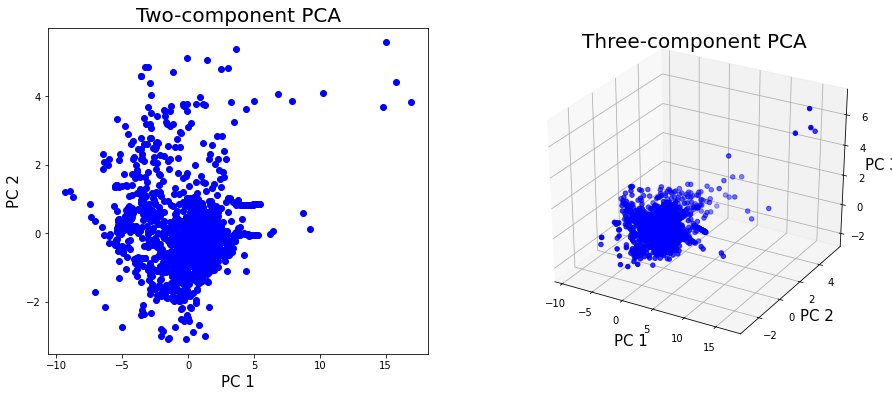

In [43]:
# Représentation dans l'espace principal (2D et 3D)

fig = plt.figure(figsize = (15,6))

ax = fig.add_subplot(1,2,1)
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Two-component PCA', fontsize = 20)
plt.scatter(principalDf["principal component 1"], principalDf["principal component 2"], color='b')


ax3 = fig.add_subplot(1,2,2,projection='3d')
#ax3 = plt.axes(projection='3d')
ax3.set_xlabel('PC 1', fontsize = 15)
ax3.set_ylabel('PC 2', fontsize = 15)
ax3.set_zlabel('PC 3', fontsize = 15)
ax3.set_title('Three-component PCA', fontsize = 20)
ax3.scatter3D(principalDf3["principal component 1"], principalDf3["principal component 2"], principalDf3["principal component 3"], color='b')



### <a id="sec2-1-2"></a> b. Méthodes de détection

Pour détecter les anomalies, nous allons utiliser quatre méthodes :
- Elliptic Envelope (with the Mahalanobis distance)
- Isolation Forest
- Local Outlier Factor (LOF)
- One-class SVM

In [44]:
def fit_predict(df, clf):
    clf.fit(df)
    ypred = clf.predict(df)
    return ypred

# Affichage dans le plan principal des anomalies
def plot2D(df, clf_name, contaminations, fig, ypred, i):
    ax = fig.add_subplot(int(len(contaminations)+1/2),2,i+1)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('2 component PCA \n Method : {} \n Contamination rate : {}'.format(clf_name,round(contaminations[i],3)))
    plt.scatter(df["principal component 1"], df["principal component 2"], color='b', label='Valid data')
    plt.plot(df["principal component 1"][ypred==-1],df["principal component 2"][ypred==-1],'r.', label='Anomalies')
    plt.legend(loc='upper right')
    
def plot3D(df, clf_name, contaminations, fig, ypred, i):
    ax = fig.add_subplot(int(len(contaminations)+1/2),2,i+1, projection='3d')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('3 component PCA \n Method : {} \n Contamination rate : {}'.format(clf_name,round(contaminations[i],3)))
    ax.scatter3D(df["principal component 1"], df["principal component 2"], df["principal component 3"], color='b', label='Valid data')
    ax.scatter3D(df["principal component 1"][ypred==-1],df["principal component 2"][ypred==-1], df["principal component 3"][ypred==-1], color='r', label='Anomalies')
    plt.legend(loc='upper right')

In [45]:
# Détecte les anomalies dans le dataset en fonction de la méthode spécifiée. 
# L'affichage dans le plan principal est optionel.  
def runAnomalies(df, clf_name, contaminations, display, plot_dimension=2):
    """
        df: Pandas dataframe contenant toutes les données
        clf_name : Nom du classifieur utilisé pour la détection d'anomalies
        contaminations: Liste de contamination rates
        display: Booléen gérant la représentation graphique
        plot_dimension: Représentation en 2D ou 3D
    """
    
    predictions = []
    
    if display:
        fig = plt.figure(figsize=(20,10*int(len(contaminations)+1/2)))
    
    # One class SVM
    if clf_name == 'SVM':
        for i in range(len(contaminations)):
            # Création du classificateur
            clf = OneClassSVM(nu=contaminations[i], kernel="rbf", gamma=0.3)
            
            # Prédiction
            ypred = fit_predict(df, clf)
            predictions.append(ypred)
            
            # Affichage
            if display:
                if plot_dimension == 2:
                    plot2D(df, clf_name, contaminations, fig, ypred, i)
                elif plot_dimension == 3:
                    plot3D(df, clf_name, contaminations, fig, ypred, i)
                    
    # Elliptic Envelope
    elif clf_name == 'Elliptic':
        for i in range(len(contaminations)):
            # Création du classificateur
            clf = EllipticEnvelope(contamination=contaminations[i])
            
            # Prédiction
            ypred = fit_predict(df, clf)
            predictions.append(ypred)
            
            # Affichage
            if display:
                if plot_dimension == 2:
                    plot2D(df, clf_name, contaminations, fig, ypred, i)
                elif plot_dimension == 3:
                    plot3D(df, clf_name, contaminations, fig, ypred, i)
    
    # Isolation Forest
    elif clf_name == 'Forest':
        for i in range(len(contaminations)):
            # Création du classificateur
            clf = IsolationForest(behaviour='new', n_estimators=100, contamination=contaminations[i])
            
            # Prédiction
            ypred = fit_predict(df, clf)
            predictions.append(ypred)
            
            # Affichage
            if display:
                if plot_dimension == 2:
                    plot2D(df, clf_name, contaminations, fig, ypred, i)
                elif plot_dimension == 3:
                    plot3D(df, clf_name, contaminations, fig, ypred, i)
    
    # Local Outlier Factor
    elif clf_name == 'LOF':
        for i in range(len(contaminations)):
            # Création du classificateur
            clf = LocalOutlierFactor(n_neighbors=5, contamination=contaminations[i], novelty=True)
            
            # Prédiction
            ypred = fit_predict(df, clf)
            predictions.append(ypred)
            
            # Affichage
            if display:
                if plot_dimension == 2:
                    plot2D(df, clf_name, contaminations, fig, ypred, i)
                elif plot_dimension == 3:
                    plot3D(df, clf_name, contaminations, fig, ypred, i)
    
    # Message d'erreur
    else:
        print("Error : The method is not known. Please select either 'SVM', 'Elliptic', 'Forest' or 'LOF'.")
    
    # Renvoie la dernière prédiction
    return predictions

Dans l'exemple suivant, nous lançons quatre tests pour détecter les anomalies dans le dataset avec la méthode de Local Outlier Factor avec quatre valeurs de contamination rate

[array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([-1, -1,  1, ...,  1,  1,  1])]

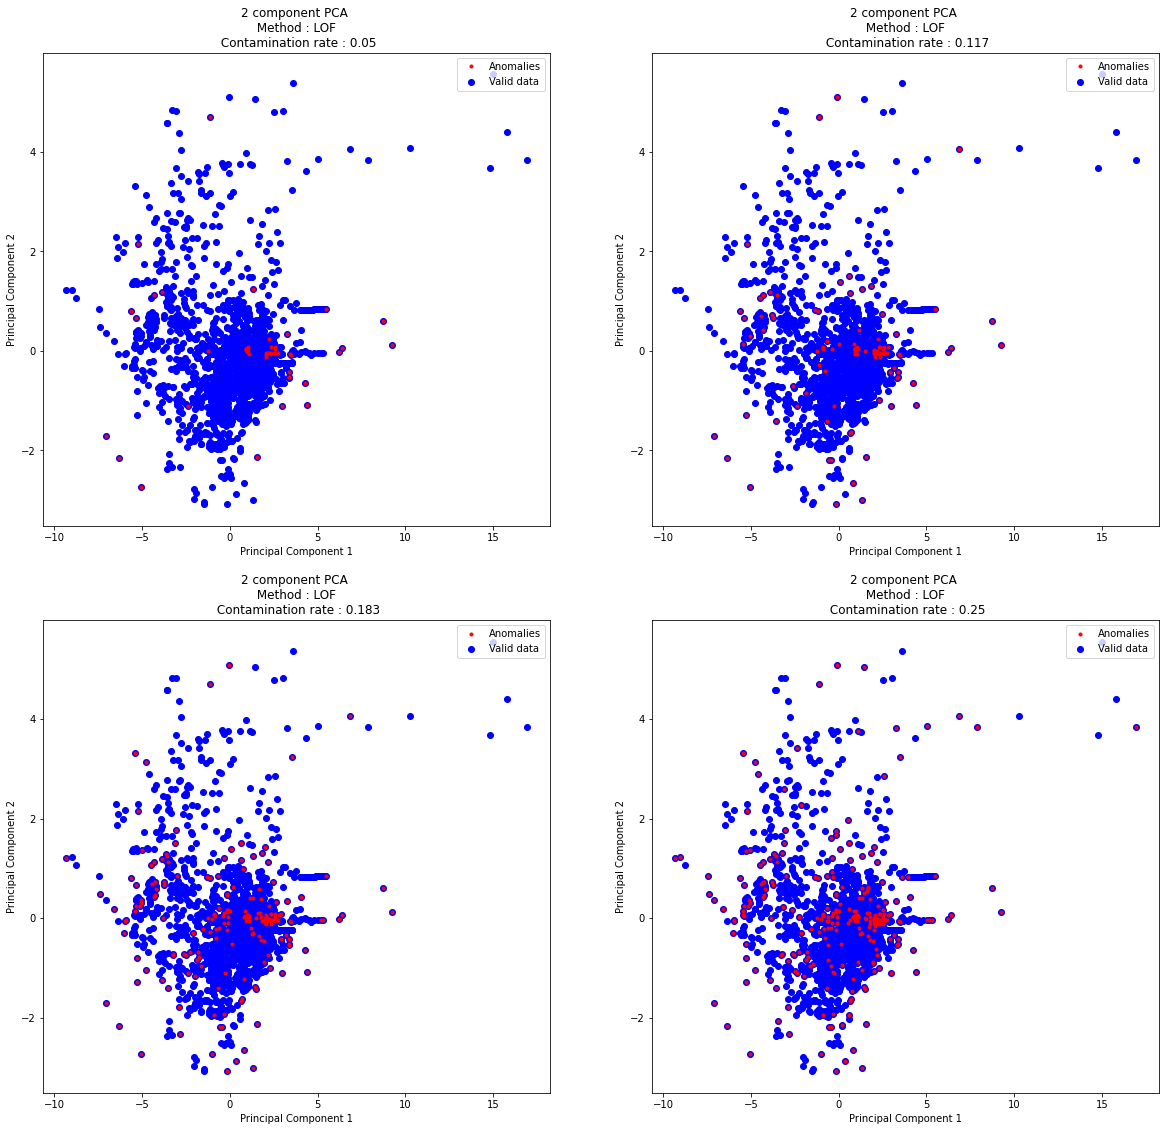

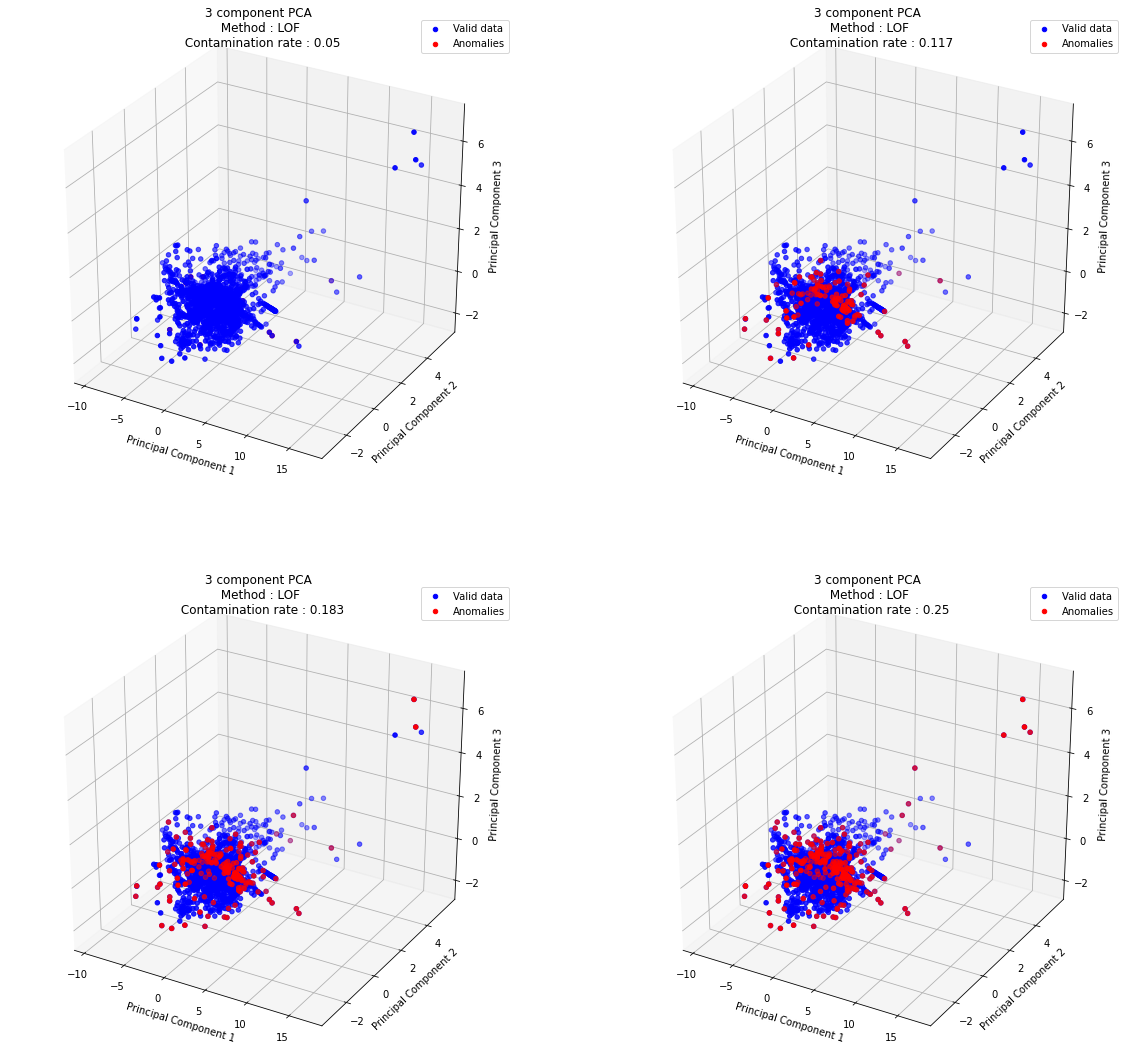

In [46]:
# Taux de contamination
contaminations = np.linspace(0.05,0.25,4)
clf_name = "LOF"

runAnomalies(principalDf, clf_name, contaminations, True, 2)
runAnomalies(principalDf3, clf_name, contaminations, True, 3)

Pour éviter un temps de calcul trop long, nous menons cette étude pour seulement une valeur de contamination rate égale à 0,1. Dans un cadre connu, cette valeur doit être adaptée en fonction du dataset. Ici, ne possédant aucune information quant à la signification des données, nous avons choisi cette valeur arbitrairement.

In [32]:
contamination_rate = 0.1

On lance les tests avec les quatre méthodes, en 2D et en 3D.

In [33]:
methods = ["Elliptic", "LOF", "SVM", "Forest"]

predictions2D = []
predictions3D = []
for clf_name in methods:
    print("Méthode : {}".format(clf_name))
    predictions2D.append(runAnomalies(principalDf, clf_name, [contamination_rate], False, 2))
    predictions3D.append(runAnomalies(principalDf3, clf_name, [contamination_rate], False, 3))

Method : Elliptic
Method : LOF
Method : SVM
Method : Forest


/home/cdrutinus/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(
/home/cdrutinus/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


### <a id="sec2-1-3"></a> c. Résultats

On regarde si une donnée est détectée par plusieurs méthodes grâce au score d'une donnée. On définit le score comme étant le nombre de méthodes qui ont détécté une fenêtre comme étant une anomalie. 

In [34]:
# Calcule le score de la fenêtre i
def score (predictions, i):
    score = 0
    for j in range(len(predictions)):
        if predictions[j][0][i] == -1:
            score += 1
    return score

# Calcul des scores des différentes fenêtres
scores2D = [score(predictions2D, i) for i in range(n_window)]
scores3D = [score(predictions3D, i) for i in range(n_window)]

On définit qu'une fenêtre est 'anormale' si elle est détectée par au moins deux méthodes

In [36]:
anomaly_windows2D = [windows[i] for i in range(n_window) if scores2D[i] > 1]
anomaly_windows3D = [windows[i] for i in range(n_window) if scores3D[i] > 1]

print("Pourcentage de fenêtres anormales en 2D : {}%".format(round(len(anomaly_windows2D)/n_window*100,2)))
print("Pourcentage de fenêtres anormales en 3D : {}%".format(round(len(anomaly_windows3D)/n_window*100,2)))

Pourcentage de fenêtres anormales en 2D : 10.57%
Pourcentage de fenêtres anormales en 3D : 10.45%


## <a id="sec2-2"></a> B. Etude de toutes les données   

Nous allons recommencer l'étude précédente, mais cette fois-ci avec toutes les données. Une fenêtre sera définie comme anormale si 50% de ses valeurs sont détectées comme étant des anomalies.

In [48]:
df = data.drop(['day_cycle_window'], axis=1)

### <a id="sec2-2-1"></a> a. Analyse en composantes principales

In [49]:
# ACP en 2D
pca_data = PCA(n_components=2)

principalComponents = pca_data.fit_transform(df)

# Tableau de coordonnées des données initiales dans le plan principal
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# Variance expliquée par les deux composantes principales
print("Variance expliquée : {}%".format(round(np.sum(pca_data.explained_variance_ratio_)*100,2)))

Variance expliquée : 74.3%


In [50]:
# ACP en 3D
pca3_data = PCA(n_components=3)

principalComponents3 = pca3_data.fit_transform(df)

# Tableau de coordonnées des données initiales dans le plan principal
principalDf3 = pd.DataFrame(data = principalComponents3
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

# Variance expliquée par les deux composantes principales
print("Variance expliquée : {}%".format(round(np.sum(pca3_data.explained_variance_ratio_)*100,2)))

Variance expliquée : 79.33%


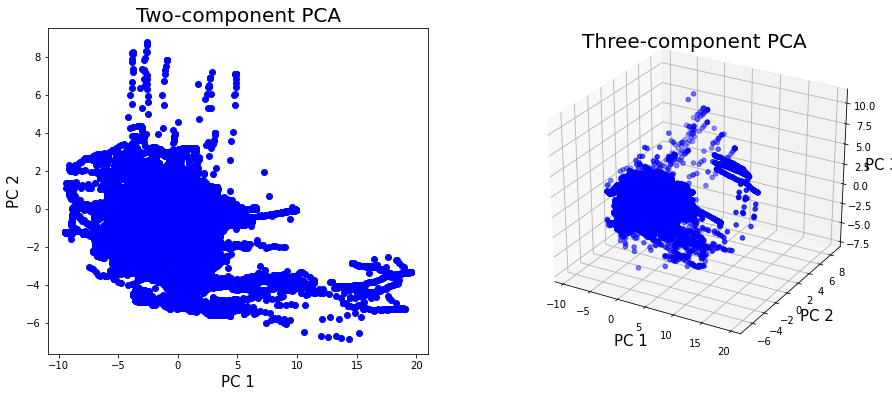

In [51]:
# Représentation dans l'espace principal

fig = plt.figure(figsize = (15,6))

ax = fig.add_subplot(1,2,1)
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Two-component PCA', fontsize = 20)
plt.scatter(principalDf["principal component 1"], principalDf["principal component 2"], color='b')

ax3 = fig.add_subplot(1,2,2,projection='3d')
ax3.set_xlabel('PC 1', fontsize = 15)
ax3.set_ylabel('PC 2', fontsize = 15)
ax3.set_zlabel('PC 3', fontsize = 15)
ax3.set_title('Three-component PCA', fontsize = 20)
ax3.scatter3D(principalDf3["principal component 1"], principalDf3["principal component 2"], principalDf3["principal component 3"], color='b')

### <a id="sec2-2-2"></a> b. Méthodes de détection

[array([1, 1, 1, ..., 1, 1, 1]),
 array([ 1,  1,  1, ...,  1,  1, -1]),
 array([ 1,  1,  1, ...,  1,  1, -1])]

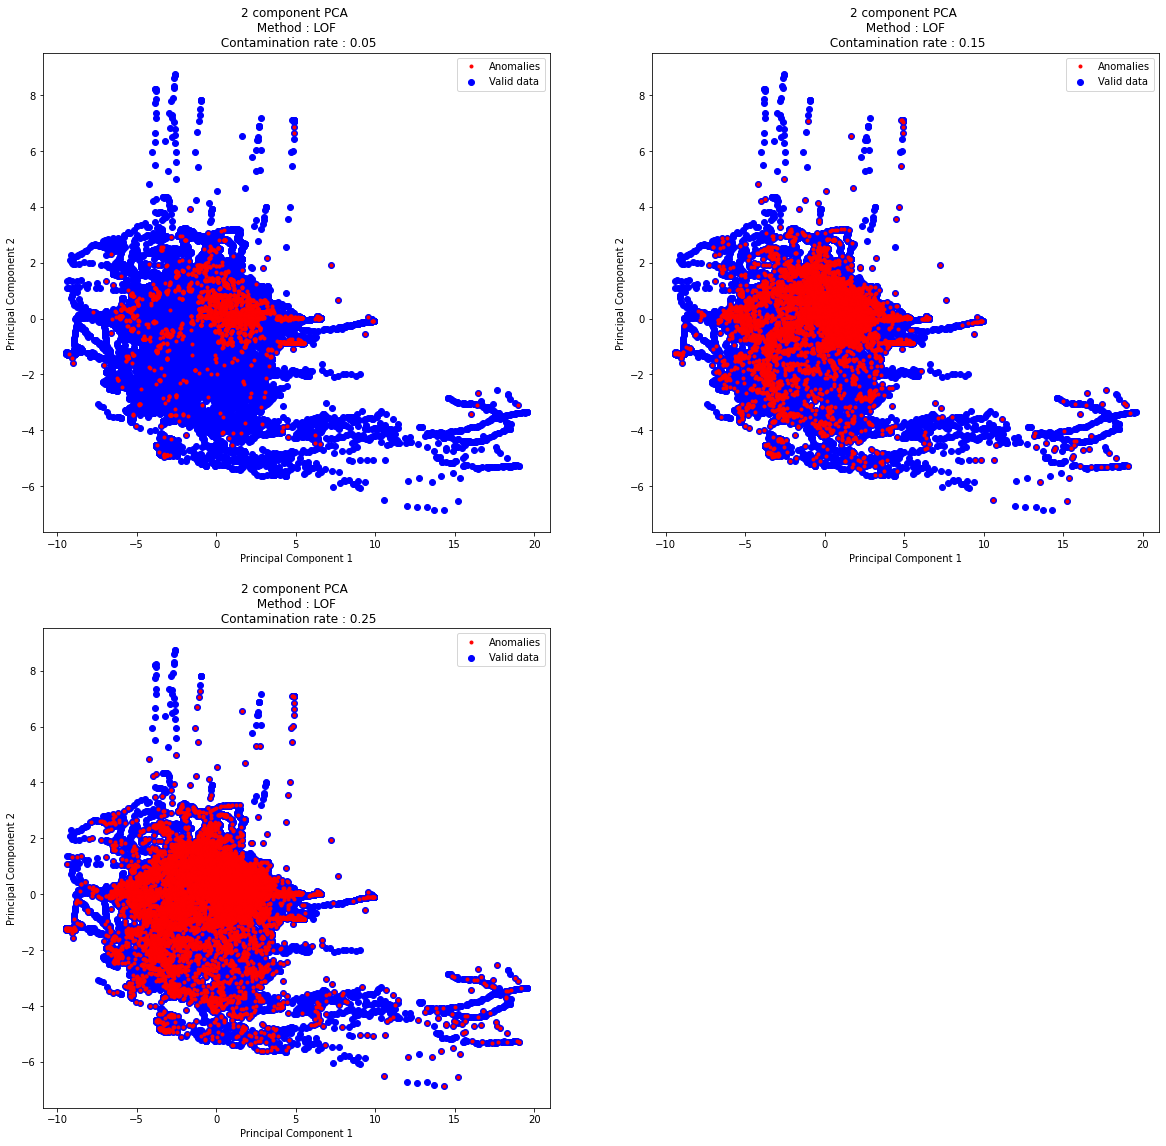

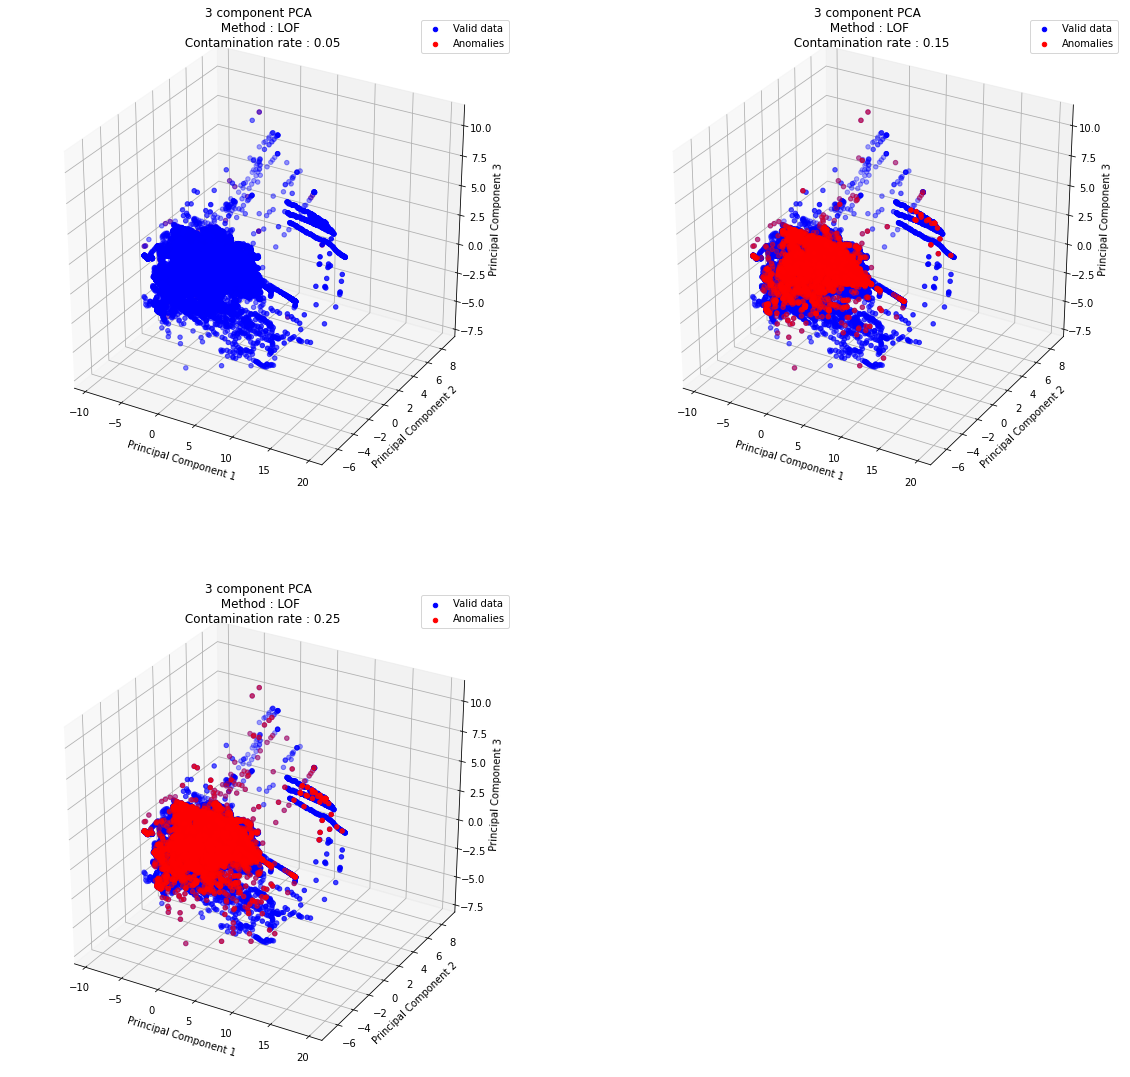

In [52]:
# Taux de contamination
contaminations = np.linspace(0.05,0.25,3)
clf_name = "LOF"

runAnomalies(principalDf, clf_name, contaminations, True, 2)
runAnomalies(principalDf3, clf_name, contaminations, True, 3)

On effectue les quatre méthodes de détection, toujours avec un contamination rate de 0,1.

In [53]:
methods = ["Elliptic", "LOF", "SVM", "Forest"]

predictions2D = []
predictions3D = []
for clf_name in methods:
    print("Méthode : {}".format(clf_name))
    print("Analyse 2D")
    predictions2D.append(runAnomalies(principalDf, clf_name, [0.1], False, 2))
    print("Analyse 3D \n")
    predictions3D.append(runAnomalies(principalDf3, clf_name, [0.1], False, 3))

Méthode : Elliptic
Analyse 2D
Analyse 3D
Méthode : LOF
Analyse 2D
Analyse 3D
Méthode : SVM
Analyse 2D
Analyse 3D
Méthode : Forest
Analyse 2D


/home/cdrutinus/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


Analyse 3D


/home/cdrutinus/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


### <a id="sec2-2-3"></a> c. Résultats

On calcule le score d'anomalie pour chaque donnée. On rajoute au tableau les colonnes 'Score 2D' et 'Score 3D'.

In [54]:
# Calcul des scores pour toutes les données
data_scores2D = [score(predictions2D, i) for i in range(n_data)]
data_scores3D = [score(predictions3D, i) for i in range(n_data)]

data["Score 2D"] = data_scores2D
data["Score 3D"] = data_scores3D

data.head()

,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,Score 2D,Score 3D
0,1_1_1,-0.805191,-1.141993,-1.328327,-1.516693,-1.373962,-0.80827,-1.070547,-0.504352,2.807146,0.495528,-1.246737,0,3
1,1_1_1,-0.805191,-1.134902,-1.320393,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.894177,0.494467,-1.244472,0,3
2,1_1_1,-0.805191,-1.117304,-1.307167,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.981904,0.429370,-1.244472,0,3
3,1_1_1,-0.814231,-1.114206,-1.287593,-1.442302,-1.287565,-0.80784,-1.045557,-0.516000,3.063298,0.348056,-1.244472,0,3
4,1_1_1,-0.848104,-1.112276,-1.285393,-1.429076,-1.270722,-0.80784,-1.017575,-0.664906,3.049237,0.118828,-1.270237,1,3


#### Première analyse:

On regarde le score moyen des données au sein de chaque fenêtre. Une fenêtre sera anormale si son score moyen est supérieur à 1.

In [55]:
df_windows = data.groupby(['day_cycle_window']).mean()

anomaly_windows2D = df_windows[df_windows["Score 2D"] > 1]
anomaly_windows3D = df_windows[df_windows["Score 3D"] > 1]

print("Pourcentage de fenêtres anormales en 2D : {}%".format(round(len(anomaly_windows2D)/n_window*100,2)))
print("Pourcentage de fenêtres anormales en 3D : {}%".format(round(len(anomaly_windows3D)/n_window*100,2)))

df_windows.head()

Pourcentage de fenêtres anormales en 2D : 12.34%
Pourcentage de fenêtres anormales en 3D : 13.32%


,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,Score 2D,Score 3D
day_cycle_window,,,,,,,,,,,,,
1_1_1,-1.926141,-2.456284,-2.487394,-2.481230,-2.388674,-1.984092,-2.447148,-1.169837,2.848242,-1.370045,-2.500060,2.63,2.40
1_1_10,1.204735,1.123558,1.077596,1.128253,1.136183,1.228688,1.199106,1.308412,-0.429810,-0.088168,1.016565,0.09,0.02
1_1_11,0.742475,0.703459,0.680578,0.740626,0.768269,0.736631,0.755362,0.783155,-0.429810,-0.091129,0.669938,0.05,0.05
1_1_12,0.300162,0.289058,0.289114,0.342999,0.396993,0.254292,0.324268,0.264819,-0.429810,-0.085217,0.303699,0.03,0.06
1_1_13,0.140935,0.152487,0.161874,0.200016,0.226986,0.083547,0.170042,0.068720,-0.429810,-0.089727,0.186059,0.29,0.30


#### Deuxième analyse:

On regarde le pourcentage de données anormales au sein de chaque fenêtre. Comme dans la première partie, nous considérerons qu'une donnée est anormale si elle a été détectée par au moins deux méthodes.
Enfin, une fenêtre sera considérée comme anormale si elle contient plus de 50% d'anomalies.

On ajoute une colonne 'Anomaly 2D' qui vaut 1 si la donnée est une anomalie, 0 sinon. On fait de même avec une colonne 'Anomaly 3D' pour l'étude en trois dimensions.

In [56]:
# Ajout de la colonne 'Anomalies'
data["Anomaly 2D"] = [data["Score 2D"][i] > 1 for i in range(n_data)]
data["Anomaly 3D"] = [data["Score 3D"][i] > 1 for i in range(n_data)]

data = data.drop(columns=["Score 2D", "Score 3D"])
data.head()

,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,Anomaly 2D,Anomaly 3D
0,1_1_1,-0.805191,-1.141993,-1.328327,-1.516693,-1.373962,-0.80827,-1.070547,-0.504352,2.807146,0.495528,-1.246737,False,True
1,1_1_1,-0.805191,-1.134902,-1.320393,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.894177,0.494467,-1.244472,False,True
2,1_1_1,-0.805191,-1.117304,-1.307167,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.981904,0.429370,-1.244472,False,True
3,1_1_1,-0.814231,-1.114206,-1.287593,-1.442302,-1.287565,-0.80784,-1.045557,-0.516000,3.063298,0.348056,-1.244472,False,True
4,1_1_1,-0.848104,-1.112276,-1.285393,-1.429076,-1.270722,-0.80784,-1.017575,-0.664906,3.049237,0.118828,-1.270237,False,True


In [57]:
# Calcul du nombre d'anomalies au sein de chaque fenêtre
df_windows = data.groupby(['day_cycle_window']).mean()

anomaly_windows2D = df_windows[df_windows["Anomaly 2D"] > 0.5]
anomaly_windows3D = df_windows[df_windows["Anomaly 3D"] > 0.5]

print("Pourcentage de fenêtres anormales en 2D : {}%".format(round(len(anomaly_windows2D)/n_window*100,2)))
print("Pourcentage de fenêtres anormales en 3D : {}%".format(round(len(anomaly_windows3D)/n_window*100,2)))

df_windows.head()

Pourcentage de fenêtres anormales en 2D : 10.2%
Pourcentage de fenêtres anormales en 3D : 8.31%


,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,Anomaly 2D,Anomaly 3D
day_cycle_window,,,,,,,,,,,,,
1_1_1,-1.926141,-2.456284,-2.487394,-2.481230,-2.388674,-1.984092,-2.447148,-1.169837,2.848242,-1.370045,-2.500060,0.93,1.0
1_1_10,1.204735,1.123558,1.077596,1.128253,1.136183,1.228688,1.199106,1.308412,-0.429810,-0.088168,1.016565,0.00,0.0
1_1_11,0.742475,0.703459,0.680578,0.740626,0.768269,0.736631,0.755362,0.783155,-0.429810,-0.091129,0.669938,0.00,0.0
1_1_12,0.300162,0.289058,0.289114,0.342999,0.396993,0.254292,0.324268,0.264819,-0.429810,-0.085217,0.303699,0.00,0.0
1_1_13,0.140935,0.152487,0.161874,0.200016,0.226986,0.083547,0.170042,0.068720,-0.429810,-0.089727,0.186059,0.00,0.0


# <a id="sec3"></a> 3. Analyse de résultats

3D plus de variance expliquée donc o  détecte moins, mais par plus de méthides